In [1]:
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud
from sklearn.manifold import TSNE

import pyLDAvis

In [2]:
sns.set(style='whitegrid')
sns.set_palette("pastel")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
print("--- 데이터 로딩 및 전처리 (모델 학습 시와 동일하게 수행) ---")

FOLDER_PATH = './text'
RANDOM_STATE = 42

# --- 1. 데이터 로딩 ---
texts_original = []
original_filenames = []
if not os.path.isdir(FOLDER_PATH):
    print(f"오류: 폴더 '{FOLDER_PATH}'를 찾을 수 없습니다.")
    exit()

print(f"'{FOLDER_PATH}' 에서 텍스트 파일 로딩 중...")
file_list = sorted([f for f in os.listdir(FOLDER_PATH) if f.endswith('.txt')])
if len(file_list) != 16: # 원본 파일 개수 확인 (예시)
    print(f"경고: 로드된 텍스트 파일 수가 16개가 아닙니다 ({len(file_list)}개). 결과 해석에 유의하세요.")

for filename in file_list:
    original_filenames.append(filename) # 파일명 저장
    file_path = os.path.join(FOLDER_PATH, filename)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            texts_original.append(f.read())
    except Exception as e:
        print(f"오류: 파일 '{filename}' 읽기 실패 - {e}")

if not texts_original:
    print("오류: 텍스트 파일 없음.")
    exit()
print(f"총 {len(texts_original)}개의 문서를 불러왔습니다.")

# --- 2. 전처리 준비 (모델 학습 시와 동일하게) ---
stop_words_nltk = stopwords.words('english')
stop_words_nltk.extend(["etc", "et al", "figure", "table", "e.g.", "i.e.", 'vol', 'pp',
                        'introduction', 'abstract', 'paper', 'author', 'fig', 'page', 'number'])
lemmatizer = WordNetLemmatizer()

# --- 3. 전처리 함수 (모델 학습 시와 동일하게) ---
def preprocess_text_simple(text):
    processed_tokens = []
    tokens = simple_preprocess(text, deacc=True)
    for token in tokens:
        if token not in stop_words_nltk and len(token) > 2 and token.isalpha():
            lemmatized_token = lemmatizer.lemmatize(token, pos='v')
            processed_tokens.append(lemmatizer.lemmatize(lemmatized_token, pos='n'))
    return processed_tokens

# --- 4. 전처리 적용 ---
print("텍스트 데이터 전처리 중...")
processed_texts_all = [preprocess_text_simple(doc) for doc in texts_original]

# --- 5. 빈 문서 제거 및 최종 텍스트 준비 ---
valid_indices = [i for i, doc in enumerate(processed_texts_all) if doc]
processed_texts = [processed_texts_all[i] for i in valid_indices]
texts_for_vectorizers = [' '.join(doc) for doc in processed_texts]
original_filenames_filtered = [original_filenames[i] for i in valid_indices]

if len(processed_texts) != len(texts_original):
     print(f"주의: 전처리 후 {len(texts_original) - len(processed_texts)}개의 빈 문서 제외됨.")
if not processed_texts:
    print("\n오류: 유효한 텍스트 데이터 없음.")
    exit()
print(f"전처리 후 유효한 문서 수: {len(processed_texts)}")
print("--- 데이터 로딩 및 전처리 완료 ---")

--- 데이터 로딩 및 전처리 (모델 학습 시와 동일하게 수행) ---
'./text' 에서 텍스트 파일 로딩 중...
총 16개의 문서를 불러왔습니다.
텍스트 데이터 전처리 중...
전처리 후 유효한 문서 수: 16
--- 데이터 로딩 및 전처리 완료 ---


In [4]:
# ==============================================================================
# 모델 및 관련 파일 로드 (JSON 로드 제외)
# ==============================================================================
print("\n--- 모델 및 관련 파일 로드 ---")

SAVE_DIR = './model_save'
k_saved = 6

nmf_model_filepath = os.path.join(SAVE_DIR, f'nmf_k{k_saved}_model_final.joblib')
vectorizer_filepath = os.path.join(SAVE_DIR, 'tfidf_vectorizer_final.joblib')
topics_filepath = os.path.join(SAVE_DIR, f'nmf_k{k_saved}_topics_final.txt')

loaded_nmf_model = None
loaded_vectorizer = None
load_successful = True

try:
    if os.path.exists(nmf_model_filepath):
        loaded_nmf_model = joblib.load(nmf_model_filepath)
        print(f"성공: NMF 모델 로드 완료 ('{nmf_model_filepath}')")
    else:
        print(f"오류: NMF 모델 파일 '{nmf_model_filepath}'을(를) 찾을 수 없습니다.")
        load_successful = False

    if os.path.exists(vectorizer_filepath):
        loaded_vectorizer = joblib.load(vectorizer_filepath)
        print(f"성공: TF-IDF Vectorizer 로드 완료 ('{vectorizer_filepath}')")
        try:
            tfidf_feature_names = loaded_vectorizer.get_feature_names_out()
            print(f"   로드된 Vectorizer로부터 {len(tfidf_feature_names)}개의 피처 이름 확인.")
        except Exception as e_feat:
            print(f"오류: 로드된 Vectorizer에서 피처 이름(get_feature_names_out)을 가져오는 데 실패했습니다 - {e_feat}")
            tfidf_feature_names = None
    else:
        print(f"오류: TF-IDF Vectorizer 파일 '{vectorizer_filepath}'을(를) 찾을 수 없습니다.")
        load_successful = False
        tfidf_feature_names = None

except Exception as e:
    print(f"오류: 모델 또는 Vectorizer 로드 중 문제 발생 - {e}")
    load_successful = False
    tfidf_feature_names = None

# --- 토픽 단어 파일 읽기 ---
topic_words_list = []
try:
    if os.path.exists(topics_filepath):
        with open(topics_filepath, 'r', encoding='utf-8') as f:
            print(f"\n--- 로드된 토픽 단어 ({topics_filepath}) ---")
            header = next(f)
            print(header.strip())
            line = ""
            for line in f:
                print(line.strip())
                try: # 파싱 오류 방지
                    topic_desc, words_str = line.strip().split(': ')
                    topic_words_list.append(words_str.split(', '))
                except ValueError:
                    print(f"  경고: 다음 라인을 파싱할 수 없습니다: {line.strip()}")
                    topic_words_list.append([])
            if line:
                 print("-" * (len(line)+1 if line else 40))
    else:
        print(f"정보: 토픽 단어 파일 '{topics_filepath}'을(를) 찾을 수 없습니다.")
except Exception as e:
    print(f"오류: 토픽 단어 파일 읽기 중 문제 발생 - {e}")

# ==============================================================================
# 로드된 NMF 모델을 사용하여 16개 논문의 토픽 예측 및 결과 출력
# ==============================================================================

if load_successful and loaded_nmf_model is not None and loaded_vectorizer is not None:
    print("\n--- 로드된 NMF 모델로 원본 논문 토픽 예측 수행 ---")

    # 1. 로드된 Vectorizer로 TF-IDF 변환
    print("1. TF-IDF 변환 중...")
    tfidf_matrix_original = loaded_vectorizer.transform(texts_for_vectorizers)
    print(f"   TF-IDF 행렬 생성 완료: shape={tfidf_matrix_original.shape}")

    # 2. 로드된 NMF 모델로 토픽 분포 예측
    print("2. 토픽 분포 예측 중...")
    topic_distribution_original = loaded_nmf_model.transform(tfidf_matrix_original)
    print("   예측 완료.")

    # 3. 가장 가능성 높은 토픽 ID 찾기
    predicted_topic_ids_original = np.argmax(topic_distribution_original, axis=1)

    # 4. 결과 DataFrame 생성 및 출력
    print("\n--- 16개 논문별 예측 토픽 결과 ---")
    results_original_df = pd.DataFrame({
        'Filename': original_filenames_filtered,
        'Predicted Topic ID': predicted_topic_ids_original
    })
    if topic_words_list:
        topic_keywords_map = {i: ', '.join(words[:5]) for i, words in enumerate(topic_words_list)}
        results_original_df['Topic Keywords (Top 5)'] = results_original_df['Predicted Topic ID'].map(topic_keywords_map).fillna('N/A')
    else:
        results_original_df['Topic Keywords (Top 5)'] = 'Keywords not loaded'

    topic_counts = results_original_df['Predicted Topic ID'].value_counts().sort_index()
    print("\n--- 토픽 ID별 논문 개수 ---")
    print(topic_counts)
    print("-" * 30)

    print("\n--- 논문별 상세 예측 결과 ---")
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        print(results_original_df.to_string(index=False))

    visualization_possible = True

else:
    print("\n오류: 모델 또는 Vectorizer 로드 실패로 인해 토픽 예측 및 시각화를 수행할 수 없습니다.")
    visualization_possible = False

print("\n--- 예측 작업 완료 ---")


--- 모델 및 관련 파일 로드 ---
성공: NMF 모델 로드 완료 ('./model_save\nmf_k6_model_final.joblib')
성공: TF-IDF Vectorizer 로드 완료 ('./model_save\tfidf_vectorizer_final.joblib')
   로드된 Vectorizer로부터 1322개의 피처 이름 확인.

--- 로드된 토픽 단어 (./model_save\nmf_k6_topics_final.txt) ---
--- NMF (k=6) Top 10 Words per Topic (Final Saved Model) ---
Topic 0: experimental, control, cognitive, function, test, platform, score, digital, variable, covid
Topic 1: museum, protocol, element, evaluation, solve, value, methodology, framework, citizen, implementation
Topic 2: rural, garden, storytelling, music, yr, score, older, subject, esteem, student
Topic 3: death, solitary, household, society, integrate, referral, ministry, resident, person, enact
Topic 4: coronavirus, distance, covid, case, infectious, outbreak, prescriber, current, isolate, situation
Topic 5: canada, ontario, map, case, heungeup, country, university, myeon, capacity, indicator
-----------------------------------------------------------------------------------


--- 토픽 모델링 결과 시각화 시작 ---

1. 토픽별 문서 개수 시각화 (막대 그래프)


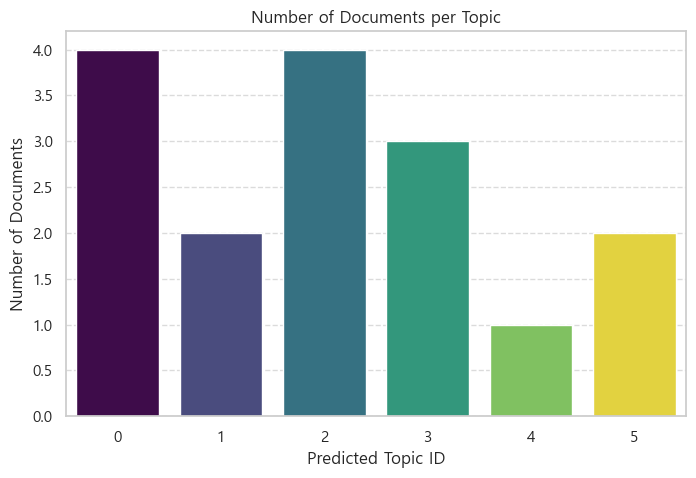


2. 문서-토픽 가중치 분포 시각화 (히트맵)


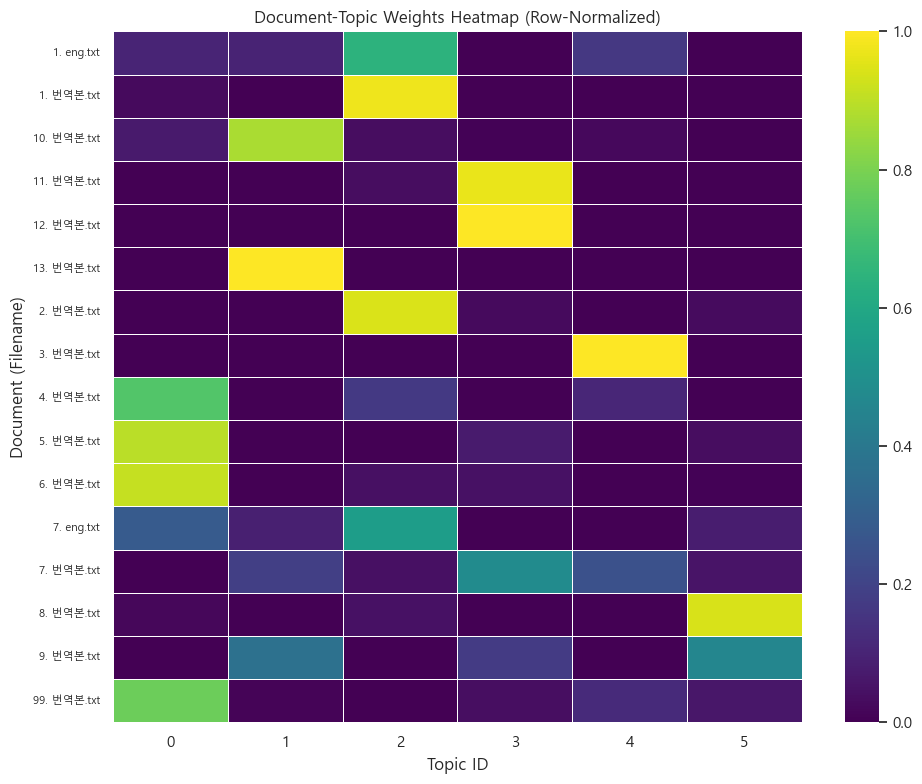


3. 토픽별 Word Cloud 시각화


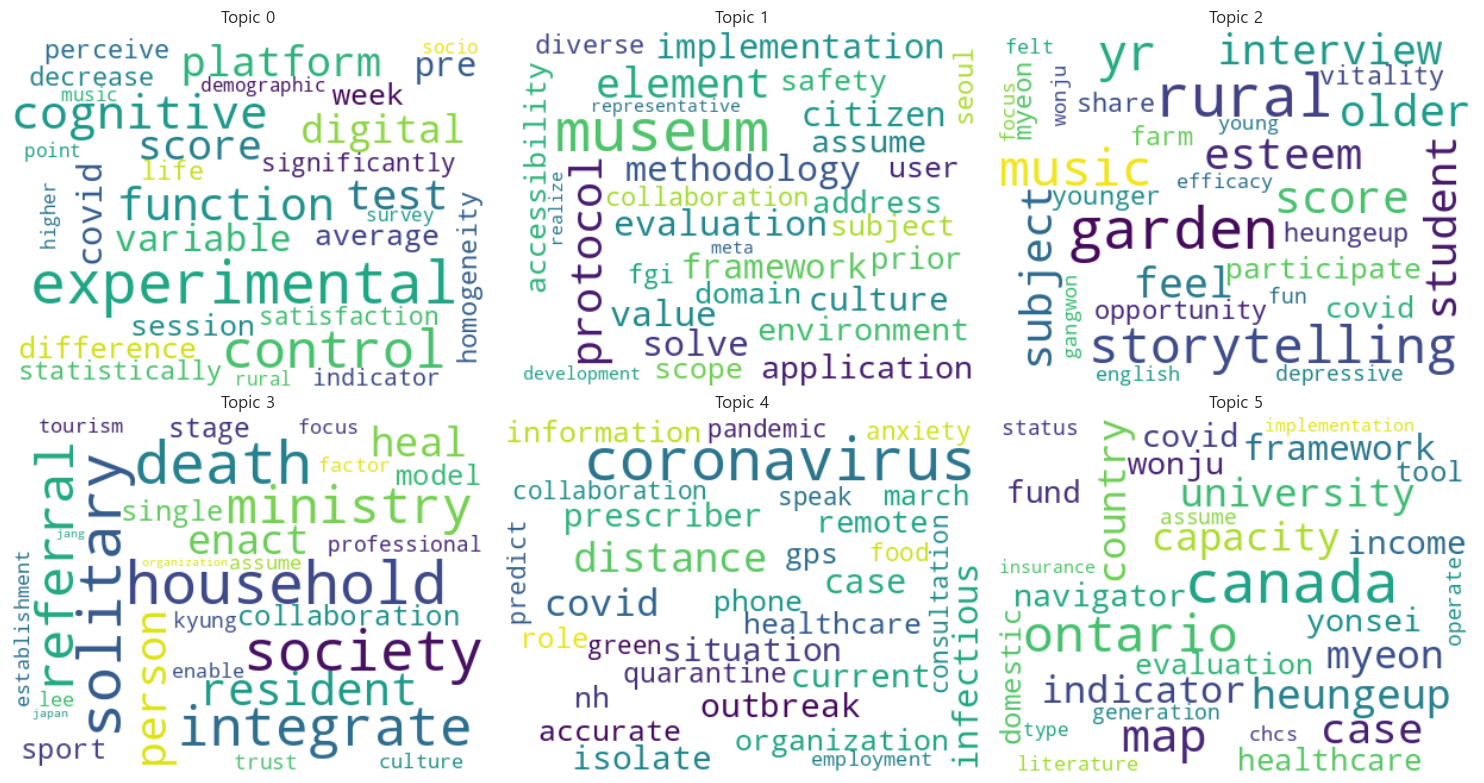


4. 토픽별 상위 단어 가중치 시각화 (막대 그래프)


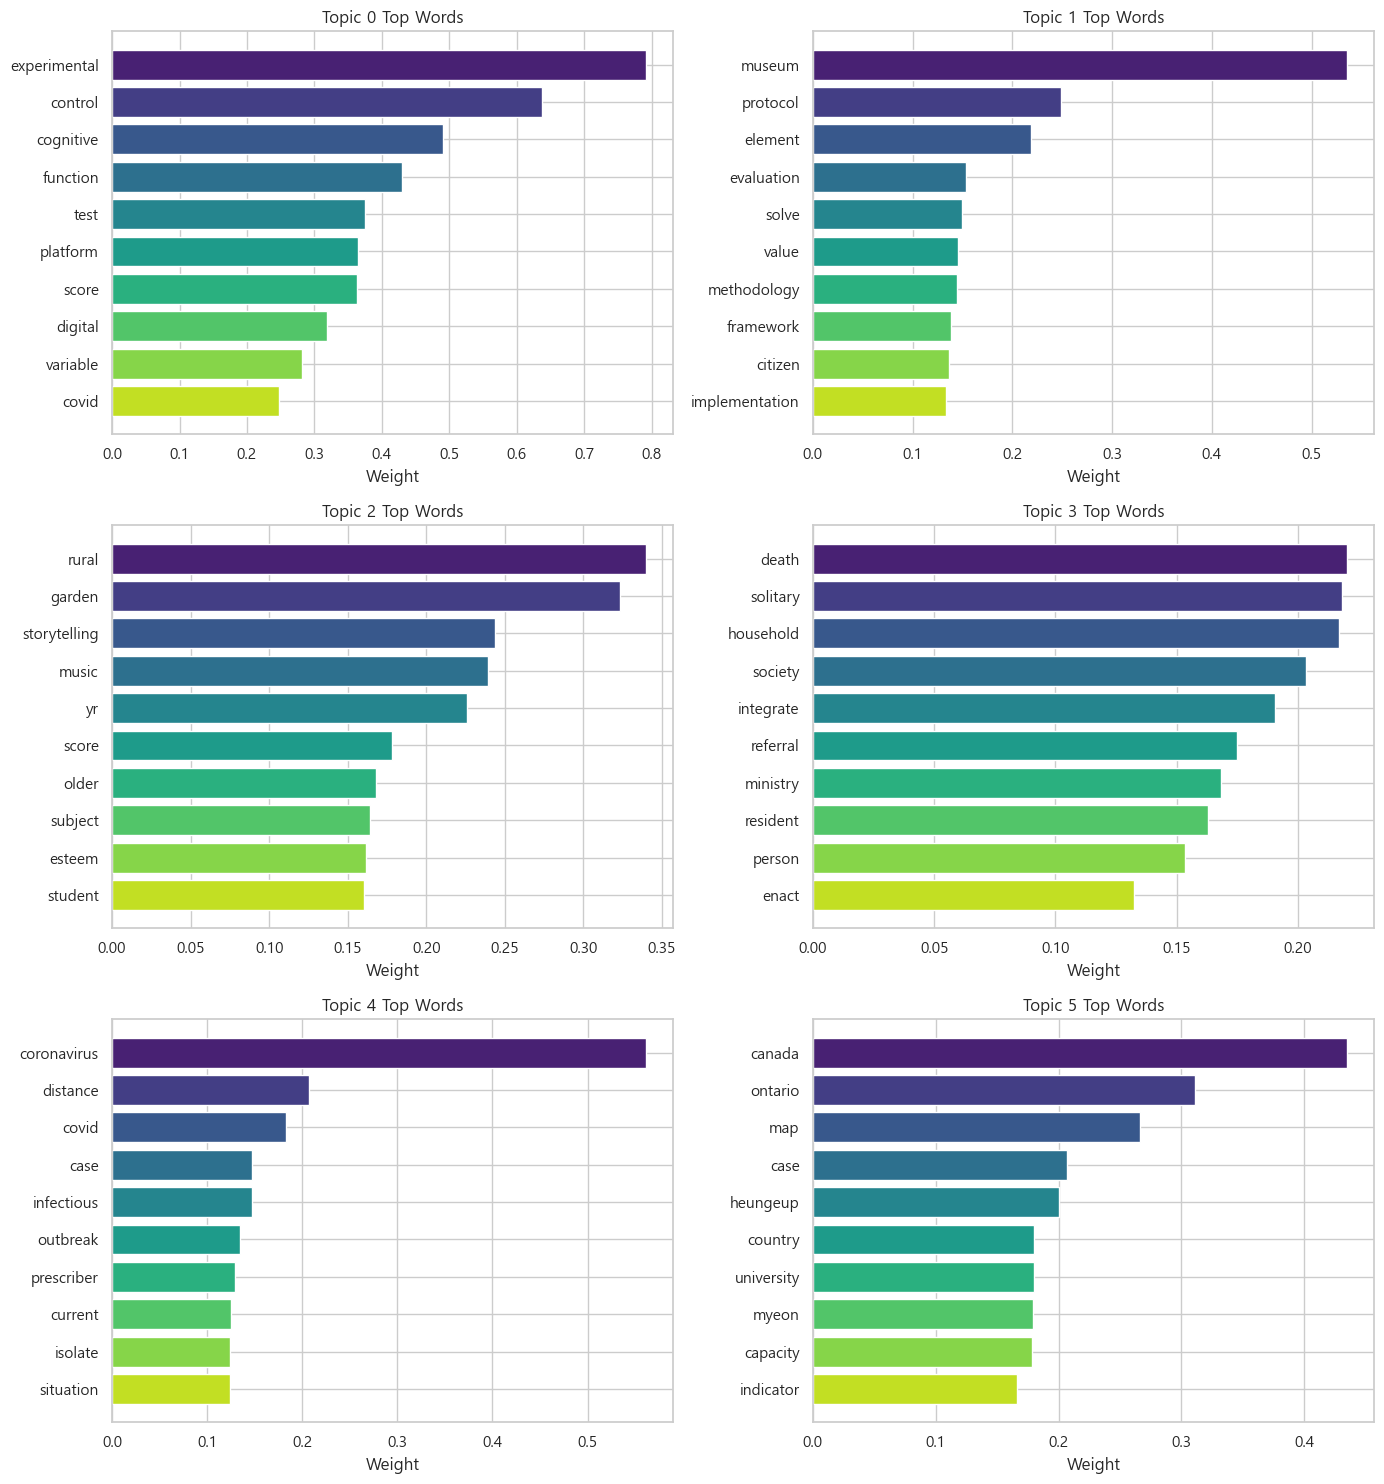

In [5]:
# ==============================================================================
# 로드된 NMF(k=6) 모델 결과 시각화
# ==============================================================================

if visualization_possible:
    required_vars_for_viz = ['results_original_df', 'topic_distribution_original',
                             'loaded_nmf_model', 'tfidf_feature_names', 'tfidf_matrix_original']
    vars_exist_for_viz = all(var in locals() or var in globals() for var in required_vars_for_viz[:-1]) and tfidf_feature_names is not None

    if not vars_exist_for_viz:
        print("오류: 시각화에 필요한 변수(결과 DataFrame, 토픽 분포, 모델 객체, TF-IDF 피처 등)가 준비되지 않았습니다.")
    else:
        print("\n--- 토픽 모델링 결과 시각화 시작 ---")

        # === 시각화 1: 토픽별 문서 개수 (막대 그래프) ===
        print("\n1. 토픽별 문서 개수 시각화 (막대 그래프)")
        try:
            plt.figure(figsize=(8, 5))
            sns.countplot(x='Predicted Topic ID', 
                          hue='Predicted Topic ID',
                          data=results_original_df,
                          palette='viridis',
                          order=sorted(results_original_df['Predicted Topic ID'].unique()),
                          legend=False)
            plt.title('Number of Documents per Topic')
            plt.xlabel('Predicted Topic ID')
            plt.ylabel('Number of Documents')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        except Exception as e:
            print(f"오류: 토픽별 문서 개수 시각화 실패 - {e}")

        # === 시각화 2: 문서-토픽 가중치 분포 (히트맵) ===
        print("\n2. 문서-토픽 가중치 분포 시각화 (히트맵)")
        try:
            row_sums = topic_distribution_original.sum(axis=1, keepdims=True)
            topic_dist_normalized = np.divide(topic_distribution_original, row_sums,
                                              out=np.zeros_like(topic_distribution_original),
                                              where=row_sums!=0)
            plt.figure(figsize=(10, 8))
            sns.heatmap(topic_dist_normalized, cmap='viridis',
                        yticklabels=results_original_df['Filename'],
                        annot=False, linewidths=.5)
            plt.title('Document-Topic Weights Heatmap (Row-Normalized)')
            plt.xlabel('Topic ID')
            plt.ylabel('Document (Filename)')
            plt.xticks(rotation=0)
            plt.yticks(rotation=0, fontsize=8)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"오류: 문서-토픽 히트맵 시각화 실패 - {e}")

        # === 시각화 3: 토픽별 Word Cloud ===
        print("\n3. 토픽별 Word Cloud 시각화")
        try:
            wordcloud_available = True
        except ImportError:
            print("오류: 'wordcloud' 라이브러리가 설치되지 않았습니다...") # 이하 동일
            wordcloud_available = False

        if wordcloud_available:
            try:
                topic_word_weights = loaded_nmf_model.components_
                num_topics = topic_word_weights.shape[0]
                num_top_words_wc = 30
                ncols_wc = 3
                nrows_wc = (num_topics + ncols_wc - 1) // ncols_wc
                fig_wc, axes_wc = plt.subplots(nrows=nrows_wc, ncols=ncols_wc, figsize=(ncols_wc * 5, nrows_wc * 4))
                axes_wc = axes_wc.flatten()

                for topic_idx in range(num_topics):
                    if topic_idx >= len(axes_wc): break
                    weights = topic_word_weights[topic_idx, :]
                    word_weight_dict = {word: weights[i] for i, word in enumerate(tfidf_feature_names)}
                    top_word_weights = {word: weight for word, weight in word_weight_dict.items() if weight > 1e-6}
                    top_word_weights = dict(sorted(top_word_weights.items(), key=lambda item: item[1], reverse=True)[:num_top_words_wc])

                    ax = axes_wc[topic_idx]
                    if not top_word_weights:
                        ax.set_title(f'Topic {topic_idx} (No words)')
                        ax.axis('off')
                        continue

                    wordcloud = WordCloud(width=400, height=300, background_color='white',
                                          max_font_size=50, colormap='viridis').generate_from_frequencies(top_word_weights)
                    ax.imshow(wordcloud, interpolation='bilinear')
                    ax.set_title(f'Topic {topic_idx}')
                    ax.axis('off')

                for j in range(topic_idx + 1, len(axes_wc)):
                     if j < len(axes_wc): fig_wc.delaxes(axes_wc[j])
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"오류: Word Cloud 생성 중 문제 발생 - {e}")

        # === 시각화 4: 토픽별 상위 단어 가중치 (막대 그래프) ===
        print("\n4. 토픽별 상위 단어 가중치 시각화 (막대 그래프)")
        try:
            topic_word_weights = loaded_nmf_model.components_
            num_topics = topic_word_weights.shape[0]
            num_top_words_bar = 10
            ncols_bar = 2
            nrows_bar = (num_topics + ncols_bar - 1) // ncols_bar
            fig_bar, axes_bar = plt.subplots(nrows=nrows_bar, ncols=ncols_bar, figsize=(ncols_bar * 7, nrows_bar * 5))
            axes_bar = axes_bar.flatten()

            for topic_idx in range(num_topics):
                if topic_idx >= len(axes_bar): break
                topic_weights = topic_word_weights[topic_idx, :]
                top_indices = topic_weights.argsort()[:-num_top_words_bar - 1:-1]
                top_weights = topic_weights[top_indices]
                 # ★★★ 수정된 tfidf_feature_names 사용 ★★★
                top_words = [tfidf_feature_names[i] for i in top_indices]

                ax = axes_bar[topic_idx]
                bars = ax.barh(range(num_top_words_bar), top_weights, align='center', color=sns.color_palette('viridis', num_top_words_bar))
                ax.set_yticks(range(num_top_words_bar))
                ax.set_yticklabels(top_words)
                ax.invert_yaxis()
                ax.set_xlabel('Weight')
                ax.set_title(f'Topic {topic_idx} Top Words')

            for j in range(topic_idx + 1, len(axes_bar)):
                if j < len(axes_bar): fig_bar.delaxes(axes_bar[j])
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"오류: 상위 단어 막대 그래프 생성 실패 - {e}")

else:
     print("\n모델/Vectorizer 로드 실패 또는 예측 실패로 인해 시각화를 건너<0xEB><0x9A><0x81>니다.")

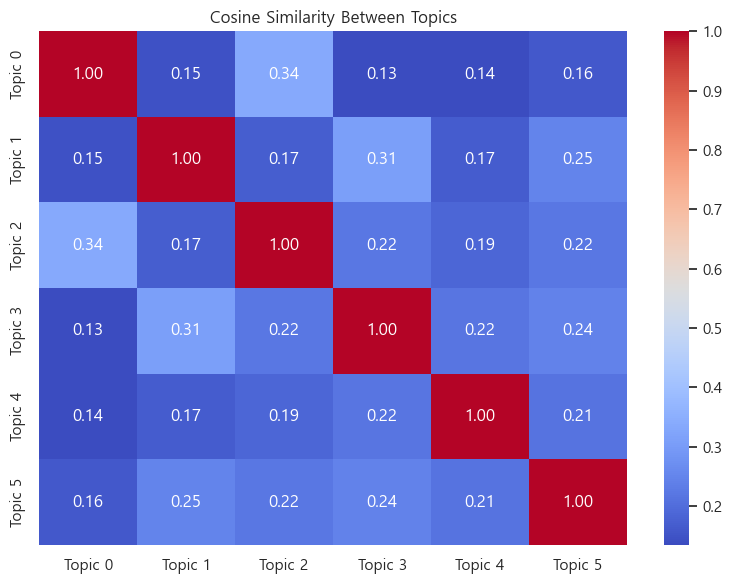

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

topic_vectors = loaded_nmf_model.components_
topic_sim_matrix = cosine_similarity(topic_vectors)

plt.figure(figsize=(8, 6))
sns.heatmap(topic_sim_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=[f'Topic {i}' for i in range(topic_vectors.shape[0])],
            yticklabels=[f'Topic {i}' for i in range(topic_vectors.shape[0])])
plt.title("Cosine Similarity Between Topics")
plt.tight_layout()
plt.show()
